In [97]:
import pybamm
import numpy as np
from pybamm.models.submodels import thermal
import liionpack as lp

/Users/jay_dggd/miniconda3/envs/thermal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-06 19:05:53,421	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [98]:
def get_thermal_mass(param):
    # Total thickness [m]
    Ln = (param['Negative current collector thickness [m]'] + param['Negative electrode thickness [m]'] + param['Separator thickness [m]'] +
        param['Positive electrode thickness [m]'] + param['Positive current collector thickness [m]'])

    # Area [m2]
    Area = param['Electrode width [m]'] * param['Electrode height [m]']

    # average specific heat capacity [J.kg-1.K-1]
    avg_cp = (
        (param['Negative current collector density [kg.m-3]'] * param['Negative current collector specific heat capacity [J.kg-1.K-1]'] * param['Negative current collector thickness [m]'] + \
        param['Negative electrode density [kg.m-3]'] * param['Negative electrode specific heat capacity [J.kg-1.K-1]'] * param['Negative electrode thickness [m]'] + \
        param['Separator density [kg.m-3]'] * param['Separator specific heat capacity [J.kg-1.K-1]'] * param['Separator thickness [m]'] + \
        param['Positive electrode density [kg.m-3]'] * param['Positive electrode specific heat capacity [J.kg-1.K-1]'] * param['Positive electrode thickness [m]'] + \
        param['Positive current collector density [kg.m-3]'] * param['Positive current collector specific heat capacity [J.kg-1.K-1]'] * param['Positive current collector thickness [m]']) \
        /(param['Negative current collector density [kg.m-3]'] * param['Negative current collector thickness [m]'] +
        param['Negative electrode density [kg.m-3]'] * param['Negative electrode thickness [m]'] +
        param['Separator density [kg.m-3]'] * param['Separator thickness [m]'] +
        param['Positive electrode density [kg.m-3]'] * param['Positive electrode thickness [m]'] +
        param['Positive current collector density [kg.m-3]'] * param['Positive current collector thickness [m]']))

    # average density [kg.m-3]
    avg_rho = (param['Negative current collector density [kg.m-3]'] * param['Negative current collector thickness [m]'] +
        param['Negative electrode density [kg.m-3]'] * param['Negative electrode thickness [m]'] +
        param['Separator density [kg.m-3]'] * param['Separator thickness [m]'] +
        param['Positive electrode density [kg.m-3]'] * param['Positive electrode thickness [m]'] +
        param['Positive current collector density [kg.m-3]'] * param['Positive current collector thickness [m]'])/ (
            Ln
        )
    return param["Cell volume [m3]"] * avg_rho *  avg_cp #thermal mass [J.K-1]

In [99]:
def make_new_model(model, param, disc, update_input):
  model1 = model.new_copy()
  param1 = param.copy()
  param1.update(update_input, check_already_exists=False)
  model1 = param1.process_model(model1, inplace=False)
  built_model = disc.process_model(model1, inplace=True, check_model=True)
  return built_model

In [100]:
output_variables = ["Volume-averaged cell temperature [K]", 
                    "Ohmic heating [W.m-3]",
                    "X-averaged Ohmic heating [W.m-3]",
                    "Volume-averaged Ohmic heating [W.m-3]",
                    "Irreversible electrochemical heating [W.m-3]",
                    "X-averaged irreversible electrochemical heating [W.m-3]",
                    "Volume-averaged irreversible electrochemical heating [W.m-3]",
                    "Reversible heating [W.m-3]",
                    "X-averaged reversible heating [W.m-3]",
                    "Volume-averaged reversible heating [W.m-3]",
                    "Total heating [W.m-3]",
                    "X-averaged total heating [W.m-3]",
                    "Volume-averaged total heating [W.m-3]",
                    ]

In [101]:
options={
            "thermal": "isothermal",
            "calculate heat source for isothermal models": "true"
        }

model = pybamm.lithium_ion.SPMe(options=options)

param = pybamm.ParameterValues("Chen2020").copy()
geometry = model.default_geometry
submesh_types = model.default_submesh_types
var_pts = model.default_var_pts
spatial_methods = model.default_spatial_methods

param.process_geometry(geometry)
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
disc = pybamm.Discretisation(mesh, spatial_methods)

solutions = []

In [20]:
current = 10
update_input = {
        "Current function [A]": current,
        "Ambient temperature [K]": 310,
        "Initial temperature [K]": 310,
        "Negative tab heat transfer coefficient [W.m-2.K-1]": 0,
        "Positive tab heat transfer coefficient [W.m-2.K-1]": 0,
        "Total heat transfer coefficient [W.m-2.K-1]": 0,
    }
model1 = make_new_model(model, param, disc, update_input)

solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)

step_solution = solver.step(pybamm.EmptySolution(),
                            model1,
                            1,
                            npts=10,
                            save=False,)

solutions += [step_solution]



In [35]:
t = np.linspace(0,1, 10)
y = step_solution['X-averaged total heating [W.m-3]'](t=t)

delta_t = np.trapz(y, t) * param["Cell volume [m3]"]/(get_thermal_mass(param))
delta_t

0.052650923746567366

In [46]:
step_solution["Resistance [Ohm]"](t=1)

array(0.39791786)

In [53]:
(step_solution['Surface open-circuit voltage [V]'](t=1) - step_solution['Voltage [V]'](t=1))/step_solution['Current [A]'](t=1)

0.019227447697927325

In [52]:
(step_solution['Surface open-circuit voltage [V]'](t=1) - step_solution['Voltage [V]'](t=1))/step_solution['Current [A]'](t=1)

array(10.)

In [61]:
step_solution['Total heating [W.m-3]'](t=1)

array([129512.31719659, 129908.2351042 , 130304.1530118 , 131099.86302507,
       132295.63947662, 133891.49748159, 135887.47624395, 138283.67482343,
       141080.33761392, 144278.05345982, 147878.20673192, 151883.96736811,
       156302.38467362, 161148.62034803, 166454.03380916, 172280.50859043,
       178743.28705054, 186041.82182915, 194490.16691415, 204525.31181489,
       213106.29292258,  60753.87821977,  35911.76324295,  35848.94968259,
        35796.3910722 ,  35754.2424379 ,  35722.64196688,  35701.71011826,
        35691.54881368,  35692.24073174,  35703.84872794,  35726.41539808,
        35759.96279797,  35804.49232726,  35859.98477865,  35926.40054871,
        36003.68000083,  36091.74396634,  36190.49436686,  36299.81493888,
        46719.54176491,  83113.68535948,  77631.37410827,  71746.67077652,
        66990.68360986,  63188.37965269,  60197.807336  ,  57913.47241059,
        56262.70552072,  55198.5634909 ,  54692.3189845 ,  54727.17930885,
        55293.70591214,  

In [63]:
step_solution['Volume-averaged irreversible electrochemical heating [W.m-3]'](t=1)

array(65850.13384762)

In [64]:
step_solution["Volume-averaged Ohmic heating [W.m-3]"](t=1)

array(27368.55440138)

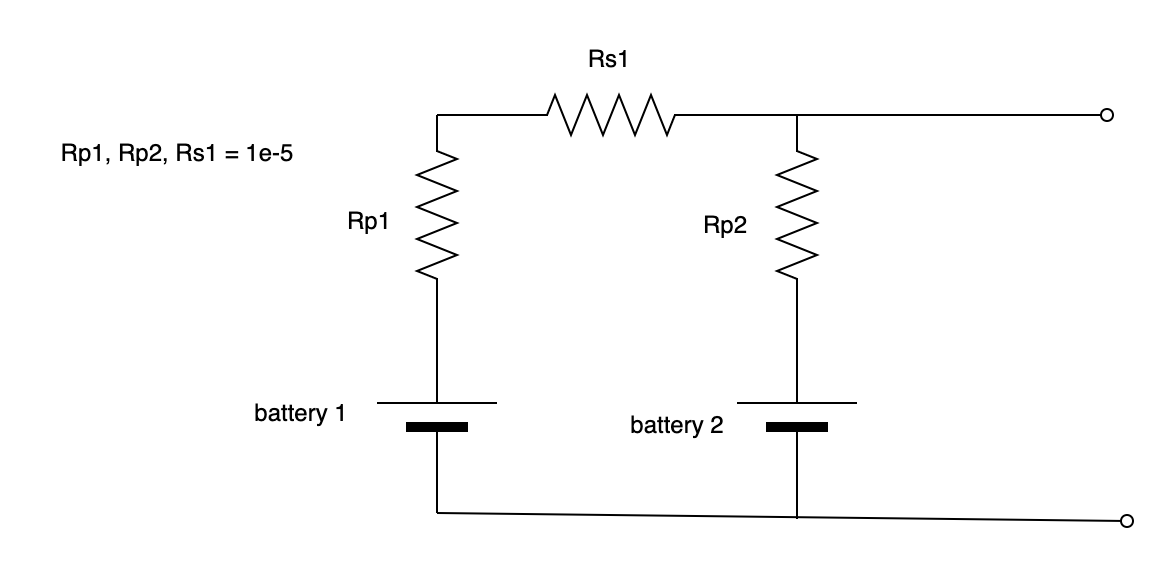

In [65]:
from IPython import display
display.Image("Two Bat Circuit.png")

$I_1 = \frac{I*R_2 + V_2 - V_1}{R_1 + R_{s1} + R_2}$

$I_2 = I - I_1$

$R_1 = R_{p1} + R_{bat1}$

$R_2 = R_{p2} + R_{bat2}$

In [114]:
def thermal_simulation(parameter_values=None):
    """
    Create a Basic PyBaMM simulation set up for integration with liionpack

    Args:
        parameter_values (pybamm.ParameterValues):
            The default is None.

    Returns:
        pybamm.Simulation:
            A simulation that can be solved individually or passed into the
            liionpack solve method

    """
    options={
            "thermal": "isothermal",
            "calculate heat source for isothermal models": "true"
        }

    # Create the pybamm model
    model = pybamm.lithium_ion.SPMe(options=options)

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        param = pybamm.ParameterValues("Chen2020")
    else:
        param = parameter_values.copy()

    # Set up solver and simulation
    solver = pybamm.CasadiSolver(mode="safe")
    sim = pybamm.Simulation(
        model=model,
        parameter_values=param,
        solver=solver,
    )
    return sim


def update_params(param, curr, cell_temp, update=True):
    update_input = {
        "Current function [A]": curr,
        "Ambient temperature [K]": cell_temp,
        "Initial temperature [K]": cell_temp,
        "Negative tab heat transfer coefficient [W.m-2.K-1]": 0,
        "Positive tab heat transfer coefficient [W.m-2.K-1]": 0,
        "Total heat transfer coefficient [W.m-2.K-1]": 0,
    }
    if update:
        param.update(update_input, check_already_exists=False)
        return None

def _create_casadi_objects_V2(inputs, sim, dt, Nspm, nproc, variable_names, mapped):
    """
    Internal function to produce the casadi objects in their mapped form for
    parallel evaluation

    Args:
        inputs (dict):
            initial guess for inputs (not used for simulation).
        sim (pybamm.Simulation):
            A PyBaMM simulation object that contains the model, parameter values,
            solver, solution etc.
        dt (float):
            The time interval (in seconds) for a single timestep. Fixed throughout
            the simulation
        Nspm (int):
            Number of individual batteries in the pack.
        nproc (int):
            Number of parallel processes to map to.
        variable_names (list):
            Variables to evaluate during solve. Must be a valid key in the
            model.variables
        mapped (bool):
            Use the mapped casadi objects, default is True

    Returns:
        integrator (mapped casadi.integrator):
            Solves an initial value problem (IVP) coupled to a terminal value
            problem with differential equation given as an implicit ODE coupled
            to an algebraic equation and a set of quadratures
        variables_fn (mapped variables evaluator):
            evaluates the simulation and output variables. see casadi function
        t_eval (np.ndarray):
            Float array of times to evaluate.
            times to evaluate in a single step, starting at zero for each step
        events_fn (mapped events evaluator):
            evaluates the event variables. see casadi function

    """
    solver = sim.solver
    # Initial solution - this builds the model behind the scenes
    sim.build()
    initial_solutions = []
    init_sol = sim.step(
        dt=1e-6, save=False, starting_solution=None, inputs=inputs[0]
    ).last_state
    # evaluate initial condition
    model = sim.built_model
    y0_total_size = (
        model.len_rhs + model.len_rhs_sens + model.len_alg + model.len_alg_sens
    )
    y_zero = np.zeros((y0_total_size, 1))
    for inpt in inputs:
        inputs_casadi = casadi.vertcat(*[x for x in inpt.values()])
        initial_solutions.append(init_sol.copy())
        _init = model.initial_conditions_eval(0, y_zero, inputs_casadi)
        initial_solutions[-1].y[:] = _init

    # Step model forward dt seconds
    t_eval = np.linspace(0, dt, 11)

    # No external variables - Temperature solved as lumped model in pybamm
    # External variables could (and should) be used if battery thermal problem
    # Includes conduction with any other circuits or neighboring batteries
    # inp_and_ext.update(external_variables)
    inp_and_ext = inputs

    # Code to create mapped integrator
    integrator = solver.create_integrator(
        sim.built_model, inputs=inp_and_ext, t_eval=t_eval
    )
    if mapped:
        integrator = integrator.map(Nspm, "thread", nproc)
    # Get the input parameter order
    ip_order = inputs[0].keys()
    # Variables function for parallel evaluation
    casadi_objs = sim.built_model.export_casadi_objects(
        variable_names=variable_names, input_parameter_order=ip_order
    )
    variables = casadi_objs["variables"]
    t, x, z, p = (
        casadi_objs["t"],
        casadi_objs["x"],
        casadi_objs["z"],
        casadi_objs["inputs"],
    )
    variables_stacked = casadi.vertcat(*variables.values())
    variables_fn = casadi.Function("variables", [t, x, z, p], [variables_stacked])
    if mapped:
        variables_fn = variables_fn.map(Nspm, "thread", nproc)

    # Look for events in model variables and create a function to evaluate them
    all_vars = sorted(sim.model.variables.keys())
    event_vars = [v for v in all_vars if "Event" in v]
    if len(event_vars) > 0:
        # Variables function for parallel evaluation
        casadi_objs = sim.built_model.export_casadi_objects(
            variable_names=variable_names, input_parameter_order=ip_order
        )
        events = casadi_objs["variables"]
        t, x, z, p = (
            casadi_objs["t"],
            casadi_objs["x"],
            casadi_objs["z"],
            casadi_objs["inputs"],
        )
        events_stacked = casadi.vertcat(*events.values())
        events_fn = casadi.Function("variables", [t, x, z, p], [events_stacked])
        if mapped:
            events_fn = events_fn.map(Nspm, "thread", nproc)
    else:
        events_fn = None

    output = {
        "integrator": integrator,
        "variables_fn": variables_fn,
        "t_eval": t_eval,
        "event_names": event_vars,
        "events_fn": events_fn,
        "initial_solutions": initial_solutions,
    }
    return output


In [112]:
def get_I1(circuit_dict):
    I = circuit_dict["I"]
    R2 = circuit_dict["R2"]
    V2 = circuit_dict["V2"]
    V1 = circuit_dict["V1"]
    R1 = circuit_dict["R1"]
    Rs1 = circuit_dict["Rs1"]
    return (I*R2 + V2 - V1) / (R1 + Rs1 + R2)

def get_I2(circuit_dict):
    I1 = circuit_dict["I1"]
    return circuit_dict["I"] - I1

def get_R1(circuit_dict):
    return circuit_dict["Rs1"] + circuit_dict["Rbat1"]

def get_R2(circuit_dict):
    return circuit_dict["Rp2"] + circuit_dict["Rbat2"]

def update_circuit_all(circuit_dict):
    circuit_dict["R1"] = get_R1(circuit_dict)
    circuit_dict["R2"] = get_R2(circuit_dict)
    circuit_dict["I1"] = get_I1(circuit_dict)
    circuit_dict["I2"] = get_I2(circuit_dict)
    return circuit_dict


circuit_dict = {"Rp1":1e-5, "Rp2":1e-5, "Rs1":1e-5, "Rbat1":1e-5, "Rbat2":1e-5, "V1":4.2, "V2":4.2, "I":1, "I1":0, "I2":0}

In [124]:
## Solve for the initial current
current = 10

circuit_dict["I"] = 10

circuit_dict = update_circuit_all(circuit_dict)

V_ocv = [0, 0]
Rin = [0, 0]
Iinput = [circuit_dict["I1"], circuit_dict["I2"]]
ini_SOC = [0.5, 0.5]
params = [pybamm.ParameterValues("Chen2020").copy(), pybamm.ParameterValues("Chen2020").copy()]
cell_T = [310, 310]

initial_solutions = []

## Begin Initial Solve
for index in range(2):
    param = params[index]
    _, _ = lp.update_init_conc(param, SoC=ini_SOC[index], update=True)
    _ = update_params(param, Iinput[index], cell_T[index])
    sim = thermal_simulation(param)
    casadi_objs = cco(
            inputs, sim, dt, Nspm, nproc, variable_names, mapped
    )
    initial_solutions += [sim.step(
        dt=1e-6, save=False, starting_solution=None
    ).last_state]


In [151]:
initial_solutions[0].last_state["Surface open-circuit voltage [V]"](t=10)

array(nan)

$$
  \frac{\partial T}{\partial t} \rho c_p = \nabla \cdot (k \nabla T),
$$
with the following boundary and initial conditions:
$$
  \left.\frac{\partial T}{\partial x}\right\vert_{x=0} = 0, \quad \left. k \frac{\partial T}{\partial x}\right\vert_{x=1} =   h(T\vert_{x=1} - Tair), \quad \left.T\right\vert_{t=0} = T_0,
$$
where $c$ is the concentration, $r$ the radial coordinate, $t$ time, $R$ the particle radius, $D$ the diffusion coefficient, $j$ the interfacial current density, $F$ Faraday's constant, and $c_0$ the initial concentration. 

In this example we use the following parameters:

| Symbol | Units              | Value                                          |
|:-------|:-------------------|:-----------------------------------------------|
| $k$      | W.K-1.m-1        | $10 \times 10^{-3}$                            |
| $\rho$   | kg.m-3           | $1 \times 10^{3}$                          |
| $c_p$    | J.kg-1.K-1       | $4.186 \times 10^{3}$                                          |
| $h$      | W.K-1.m-2     | $10 \times 10^{-3}$                                        |
| $Tair$    | K    | 310                          |
| $T_0$    | K    | 300                          |

In [423]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.BaseModel()

L = pybamm.Parameter("Thickness [m]")
k = pybamm.Parameter("Thermal conductivity [W.K-1.m-1]")
rho = pybamm.Parameter("Density [kg.m-3]")
cp = pybamm.Parameter("Heat capacity [J.kg-1.K-1]")
h = pybamm.Parameter("Heat transfer coefficient [W.K-1.m-2]")
Tair = pybamm.Parameter("Air temp [K]")

T = pybamm.Variable("Temperature [K]", domain="thickness")
T0 = 30

# Thermal flux
dTdt = k * pybamm.div(pybamm.grad(T))/rho/cp  # flux
model.rhs = {T: dTdt}

lbc = pybamm.Scalar(0)

rbc = -h*(pybamm.surf(T)-Tair)/k

model.boundary_conditions = {T: {"left": (lbc, "Neumann"), "right": (rbc, "Dirichlet")}}

model.initial_conditions = {T: T0}

In [424]:
model.variables = {
    "Temperature [K]": T,
    "Surface Temperature [K]": pybamm.surf(T),
}

param = pybamm.ParameterValues(
    {
        "Thickness [m]": 1.0,
        "Thermal conductivity [W.K-1.m-1]": 100,
        "Density [kg.m-3]": 1e3,
        "Heat capacity [J.kg-1.K-1]": 4.186e3,
        "Heat transfer coefficient [W.K-1.m-2]": 10,
        "Air temp [K]": 310,
    }
)

x = pybamm.SpatialVariable("x", domain=["thickness"], coord_sys="cartesian")
geometry = {"thickness": {x: {"min": pybamm.Scalar(0), "max": L}}}

param.process_model(model)
param.process_geometry(geometry)

In [425]:
submesh_types = {"thickness": pybamm.Uniform1DSubMesh}
var_pts = {x: 3}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"thickness": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

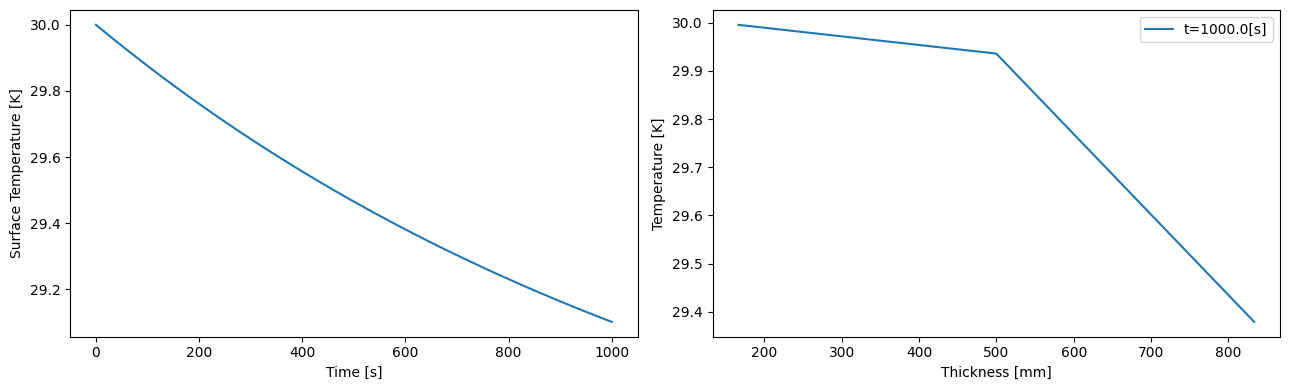

[29.9952217  29.93561082 29.37936431]


In [426]:
# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 1000, 1001)
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
T = solution["Temperature [K]"]
T_surf = solution["Surface Temperature [K]"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, T_surf(solution.t))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Surface Temperature [K]")

x = mesh["thickness"].nodes # radial position
time = t.max()  # time in seconds
ax2.plot(x * 1e3, T(t=time, x=x), label="t={}[s]".format(time))
ax2.set_xlabel("Thickness [mm]")
ax2.set_ylabel("Temperature [K]")
ax2.legend()

plt.tight_layout()
plt.show()

print(T(t=time, x=x))

### CV Ghost Cell Method
#### 3 cv
#### T1:

$$
  \frac{\partial T1}{\partial t} = \frac{k}{\rho c_p} \frac{1}{\Delta x} \left(\frac{T2-T1}{\Delta x} \right) + Q_1 \frac{1}{\rho c_p}
$$

$$
  \frac{\partial T2}{\partial t} = \frac{k}{\rho c_p} \frac{1}{\Delta x} \left(\frac{T3-T2}{\Delta x} - \frac{T2-T1}{\Delta x}\right) + Q_2 \frac{1}{\rho c_p}
$$

$$
  \frac{\partial T3}{\partial t} = \frac{1}{\rho c_p} \frac{Tair-T3}{\Delta x} h - \frac{k}{\rho c_p}\frac{1}{\Delta x}\left(\frac{T3-T2}{\Delta x} \right) + Q_3 \frac{1}{\rho c_p}
$$


In this example we use the following parameters:

| Symbol | Units              | Value                                          |
|:-------|:-------------------|:-----------------------------------------------|
| $k$      | W.K-1.m-1        | $10 \times 10^{-3}$                            |
| $\rho$   | kg.m-3           | $1 \times 10^{3}$                          |
| $c_p$    | J.kg-1.K-1       | $4.186 \times 10^{3}$                                          |
| $h$      | W.K-1.m-2     | $10 \times 10^{-3}$                                        |
| $Tair$    | K    | 310                          |
| $T_0$    | K    | 300                          |
| $Q_{1,2,3}$    | W.m-3    | 0                          |

In [427]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.BaseModel()

k = pybamm.Parameter("Thermal conductivity [W.K-1.m-1]")
rho = pybamm.Parameter("Density [kg.m-3]")
cp = pybamm.Parameter("Heat capacity [J.kg-1.K-1]")
h = pybamm.Parameter("Heat transfer coefficient [W.K-1.m-2]")
Tair = pybamm.Parameter("Air temp [K]")

T1 = pybamm.Variable("Temperature T1 [K]")
T2 = pybamm.Variable("Temperature T2 [K]")
T3 = pybamm.Variable("Temperature T3 [K]")
T0 = 30

delta_x = 1/3

# Thermal flux
dT1dt = k/rho/cp/delta_x*(T2-T1)/delta_x
dT2dt = k/rho/cp/delta_x*((T3-T2)/delta_x-(T2-T1)/delta_x)
dT3dt = 1/rho/cp*(Tair-T3)/delta_x*h-k/rho/cp/delta_x*(T3-T2)/delta_x
model.rhs = {T1: dT1dt, T2: dT2dt, T3: dT3dt}

model.initial_conditions = {T1: T0, T2: T0, T3: T0}


param = pybamm.ParameterValues(
    {
        "Thickness [m]": 1.0,
        "Thermal conductivity [W.K-1.m-1]": 100,
        "Density [kg.m-3]": 1e3,
        "Heat capacity [J.kg-1.K-1]": 4.186e3,
        "Heat transfer coefficient [W.K-1.m-2]": 10,
        "Air temp [K]": 310,
    }
)
param.process_model(model)

model.variables = {
    "Temperature T1 [K]": T1,
    "Temperature T2 [K]": T2,
    "Temperature T3 [K]": T3,
}


disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model)

solver = pybamm.CasadiSolver()
solution = solver.solve(model, np.linspace(0, 1000, 1001))

In [428]:
T1_sol = solution["Temperature T1 [K]"](t=np.linspace(0, 1000, 1001))
T2_sol = solution["Temperature T2 [K]"](t=np.linspace(0, 1000, 1001))
T3_sol = solution["Temperature T3 [K]"](t=np.linspace(0, 1000, 1001))

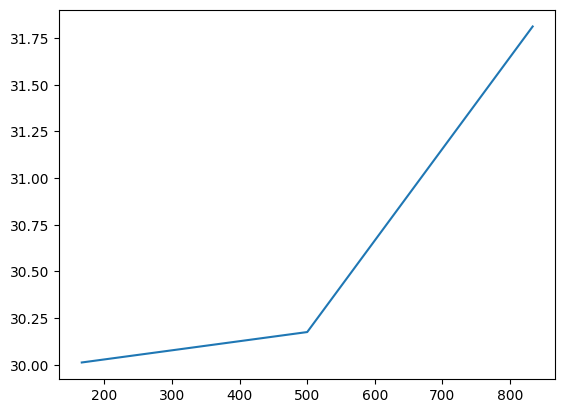

In [429]:
plt.plot(np.array([1/6, 1/2, 5/6])*1000, [T1_sol[-1], T2_sol[-1], T3_sol[-1]])

In [430]:
[T1_sol[-1], T2_sol[-1], T3_sol[-1]]

[30.012540237765187, 30.175479479221114, 31.811960145428568]